In [22]:
from matplotlib.backends.backend_pdf import PdfPages
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import pathlib
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from petitRADTRANS import Radtrans
# import petitRADTRANS.poor_mans_nonequ_chem as pm


# The wavelength ranges of each detector and order
settings = {
    'K2166': np.array([
        [[1921.318,1934.583], [1935.543,1948.213], [1949.097,1961.128]],
        [[1989.978,2003.709], [2004.701,2017.816], [2018.708,2031.165]],
        [[2063.711,2077.942], [2078.967,2092.559], [2093.479,2106.392]],
        [[2143.087,2157.855], [2158.914,2173.020], [2173.983,2187.386]],
        [[2228.786,2244.133], [2245.229,2259.888], [2260.904,2274.835]],
        [[2321.596,2337.568], [2338.704,2353.961], [2355.035,2369.534]],
        [[2422.415,2439.061], [2440.243,2456.145], [2457.275,2472.388]],
        ]), 
    }
def plot_settings(ax, setting='K2166', wave_units='um', color='k', alpha=0.1):
    n_order, n_det, _ = settings[setting].shape
    for i in range(n_order):
        for j in range(n_det):
            wave_min, wave_max = settings[setting][i][j]
            wave_factor = 1e-3 if wave_units == 'um' else 1.0
            ax.axvspan(wave_min * wave_factor, wave_max * wave_factor, color=color, alpha=alpha)
    return ax

class Linelist:
    
    def __init__(self, species, wave_min=2.35, wave_max=2.50, lbl_opacity_sampling=50):
        self.species = species
        self.wave_min = wave_min
        self.wave_max = wave_max
        self.lbl_opacity_sampling = lbl_opacity_sampling
        self.resolution = 1e6 / self.lbl_opacity_sampling
        self.radtrans = Radtrans(line_species = [species], 
                            # rayleigh_species = ['H2', 'He'],
                            # continuum_opacities = ['H2-H2', 'H2-He'],
                            rayleigh_species = [],
                            continuum_opacities = [],
                            mode='lbl',
                            wlen_bords_micron = [wave_min, wave_max],
                            lbl_opacity_sampling = lbl_opacity_sampling,
                                )
        
        self.wave_unit = 'um' # default
        
    def opacity_grid_range(self, debug=False):
        
        if self.radtrans.custom_grid[self.species]:
            print(f'- Custom grid for {self.species}')
            self.line_TP_grid = self.radtrans.custom_line_TP_grid[self.species]
            
        else:
            print(f'- Default grid for {self.species}')
            self.line_TP_grid = self.radtrans.line_TP_grid
        
        self.line_T_grid = self.line_TP_grid.T[0]
        self.line_P_grid = self.line_TP_grid.T[1]
         
        if debug:   
            print(f'- T grid: {self.line_T_grid}')
            print(f'- P grid: {self.line_P_grid}')
        return self
        
    def get_opacities(self, T):
        assert T <= (self.line_T_grid.max()+5.0), f'Temperature {T} K is out of range ({self.line_T_grid.min()} - {self.line_T_grid.max()} K)'
        self.temperature = T
        T = np.array([T]).reshape(1)
        
        self.wave_cm, self.opas = self.radtrans.get_opa(T)
        self.wave = self.wave_cm * 1e4 # convert to micron
        self.opas = np.squeeze(self.opas[self.species])
        return self
    
    
    def plot(self, ax=None, vmr=None, fill=False, fill_gradient=False, R=None, **kwargs):
        
        assert hasattr(self, 'opas'), 'No opacities found. Run get_opacities(T) first.'
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(14, 3))
            ax.set(xlabel='Wavelength (micron)', ylabel='Opacity (cm$^2$ g$^{-1}$)', 
               xlim=(self.wave_min, self.wave_max),
               yscale='log')
            
        
        
        vmr = 1.0 if vmr is None else vmr
        label = kwargs.pop('label', self.species)
        alpha = kwargs.pop('alpha', 0.8)
        if R is not None:
            alpha = 0.4
        
        # label_0 = '' if fill else label
        ax.plot(self.wave, vmr * self.opas, label=label, alpha=alpha, **kwargs)
        if R is not None:
            self.instr_broadening(out_res=R)
            ax.plot(self.wave, vmr * self.opas, lw=ax.lines[-1].get_linewidth(), ls='-', color=ax.lines[-1].get_color(),
                    alpha=0.9)
        # fill with x-axis
        if fill:
            alpha = min(0.2, kwargs.pop('alpha', 0.2))
            ax.fill_between(self.wave, 0, vmr * self.opas, alpha=alpha, 
                            **kwargs)
        if fill_gradient:
            # fill between the curve and the x-axis with a gradient
            # from white to the color of the curve
            alpha = min(0.2, kwargs.pop('alpha', 0.2))
            color = kwargs.pop('color', 'k')
            ax.fill_between(self.wave, 0, vmr * self.opas, alpha=alpha, 
                            color=color)
            ax.fill_between(self.wave, 0, vmr * self.opas, alpha=0.1,
                            color='white')

        return ax
    
    def rv_shift(self, rv):
        c = 2.99792458e5 # km/s
        self.wave = self.wave * (1.0 + rv/c)
        return self
        

    def wave_to_nm(self):
        if self.wave_unit == 'um':
            self.wave_unit = 'nm'
            self.wave = self.wave * 1e3
        return self
    
    def instr_broadening(self, out_res=1e6):

        assert hasattr(self, 'resolution'), 'No resolution attribute found...'
        assert out_res <= self.resolution, 'Output resolution must be greater than input resolution'
        assert hasattr(self, 'wave'), 'No wavelength attribute found...'
        # Delta lambda of resolution element is FWHM of the LSF's standard deviation
        sigma_LSF = np.sqrt(1/out_res**2 - 1/self.resolution**2) / \
                    (2*np.sqrt(2*np.log(2)))

        spacing = np.mean(2*np.diff(self.wave) / (self.wave[1:] + self.wave[:-1]))

        # Calculate the sigma to be used in the gauss filter in pixels
        sigma_LSF_gauss_filter = sigma_LSF / spacing
        
        # Apply gaussian filter to broaden with the spectral resolution
        self.opas = gaussian_filter(self.opas, sigma=sigma_LSF_gauss_filter, 
                                   mode='nearest'
                                   )
        return self
    
    def normalize(self):
        self.opas = self.opas / self.opas.max()
        return self

In [23]:
# load residuals
base_path = pathlib.Path('/home/dario/phd/retrieval_base/')
target = 'gl880'

# run = 'sphinx_4'
run = 'sphinx_4_v2'
file = pathlib.Path(base_path) / target / 'retrieval_outputs' / run / 'test_plots' / f'{run}_residuals.npy'

data = np.load(file)
wave, res = data[0, :], data[1, :]
n_orders = len(wave)

In [24]:
# load opacities
elements = ['Ni', 
            # 'Fe', 
            'Si',
            'Mg','K', 'Cr','Sc', 'Li', 
            'V', 'Co', 'Zn', 'Mn',
            'Cs'
            # 'Ba','Rb'
            ]
elements = [el+'_high' for el in elements]
elements += ['Mg', 'H2_main_iso']

linelists = []
for i, el in enumerate(elements):
    print(f' Loading {el}...')
    linelists.append(Linelist(el, wave_min=wave[0]*1e-3, wave_max=wave[-1]*1e-3, lbl_opacity_sampling=10)
                     .opacity_grid_range()
                     .get_opacities(3600.0 if el is not 'H2_main_iso' else 2995.0)
                     .rv_shift(-27.54)
                     
                     .instr_broadening(out_res=70e3)
                     .wave_to_nm()
                     .normalize()
                     )
    


 Loading Ni_high...


/home/dario/anaconda3/envs/retrieval/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:120: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of Ni_high...
 Done.

- Custom grid for Ni_high
 Loading Si_high...
  Read line opacities of Si_high...
 Done.

- Custom grid for Si_high
 Loading Mg_high...
  Read line opacities of Mg_high...
 Done.

- Custom grid for Mg_high
 Loading K_high...
  Read line opacities of K_high...
 Done.

- Custom grid for K_high
 Loading Cr_high...
  Read line opacities of Cr_high...
 Done.

- Custom grid for Cr_high
 Loading Sc_high...
  Read line opacities of Sc_high...
 Done.

- Custom grid for Sc_high
 Loading Li_high...
  Read line opacities of Li_high...
 Done.

- Custom grid for Li_high
 Loading V_high...
  Read line opacities of V_high...
 Done.

- Custom grid for V_high
 Loading Co_high...
  Read line opacities of Co_high...
 Done.

- Custom grid for Co_high
 Loading Zn_high...
  Read line opacities of Zn_high...
 Done.

- Custom grid for Zn_high
 Loading Mn_high...
  Read line opacities of Mn_high...
 Done.

- Custom grid for Mn_high
 Loading Mg...
  Read line opacities

AssertionError: Temperature 3600.0 K is out of range (81.14113604736988 - 2995.0 K)

Plotting Ni_high...


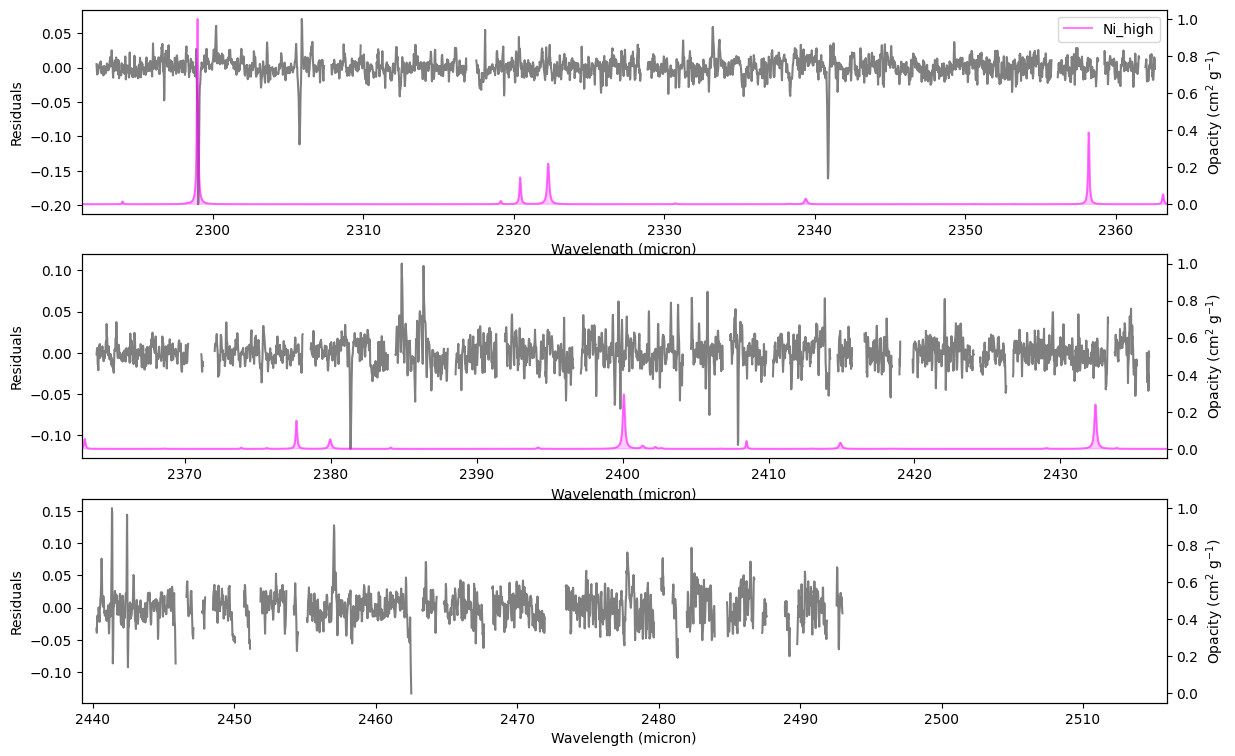

Plotting Si_high...


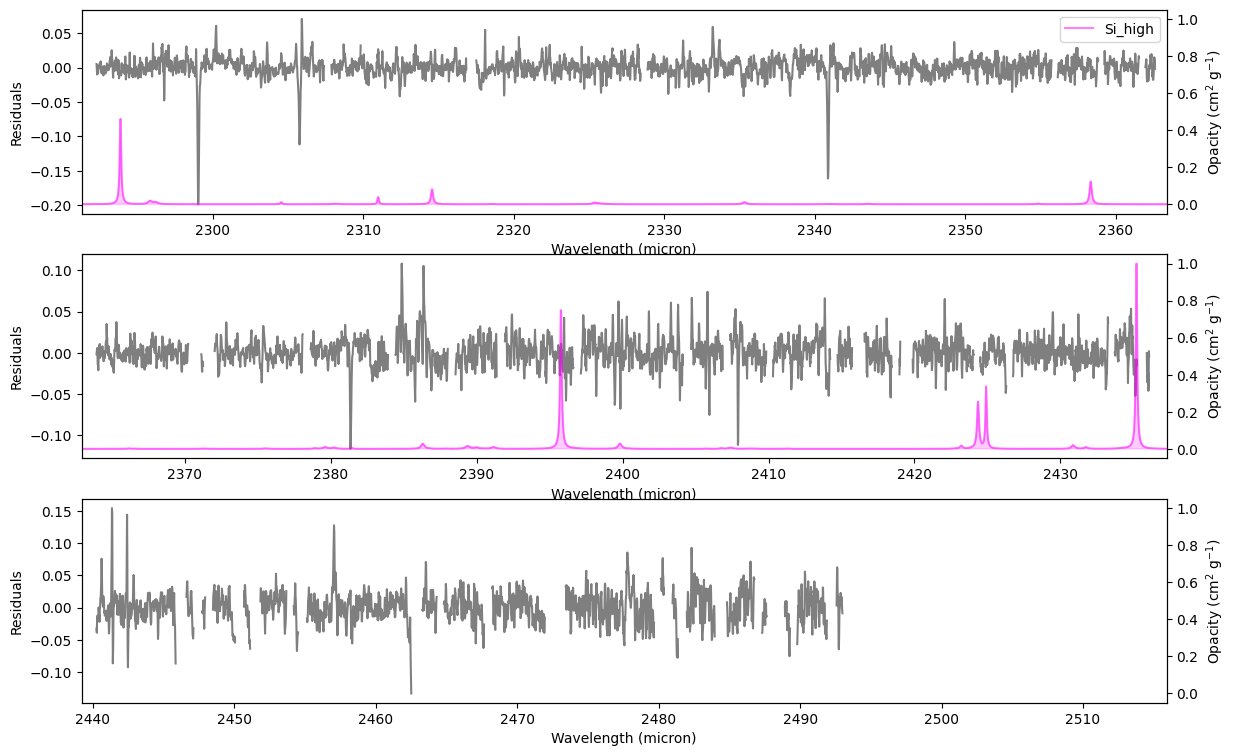

Plotting Mg_high...


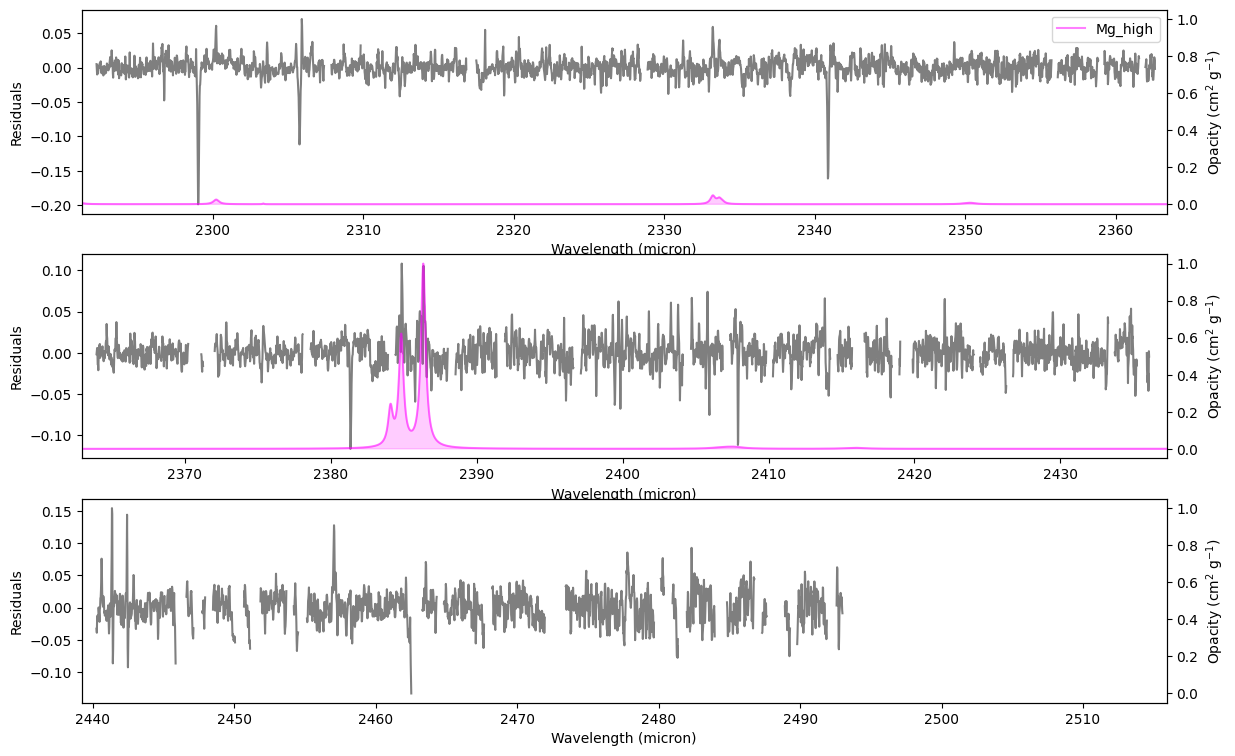

Plotting K_high...


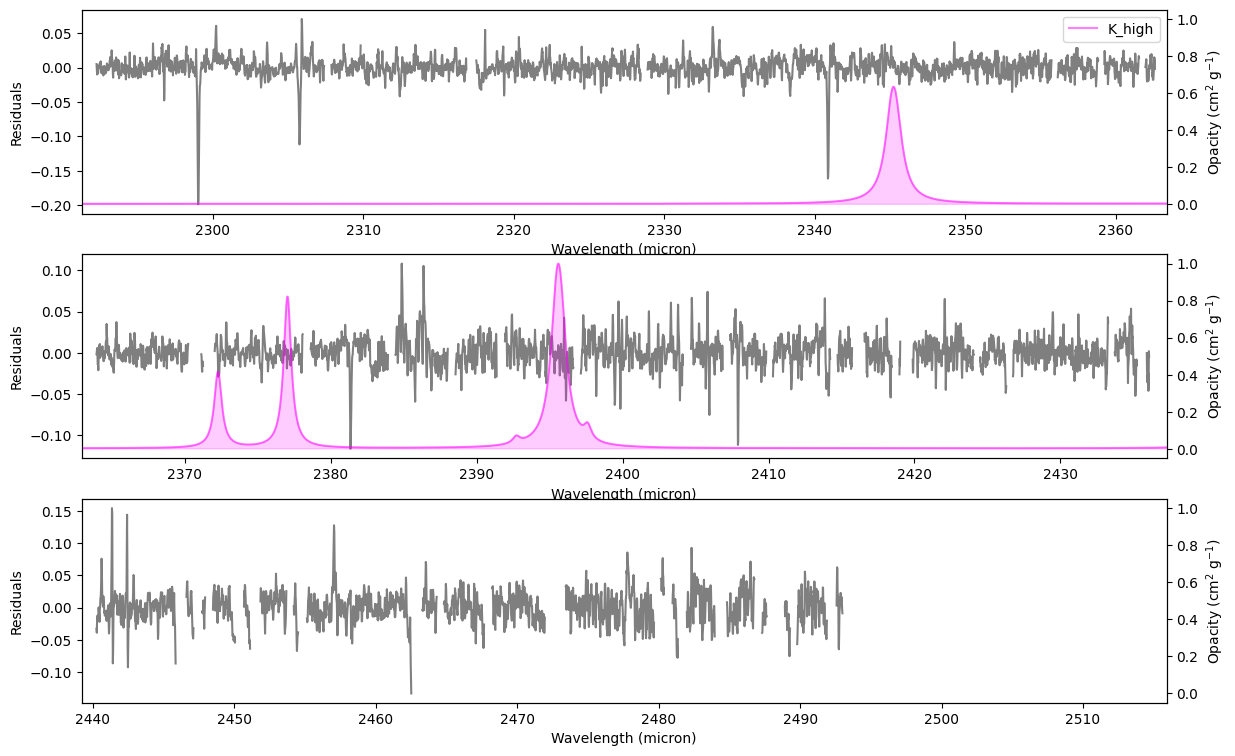

Plotting Cr_high...


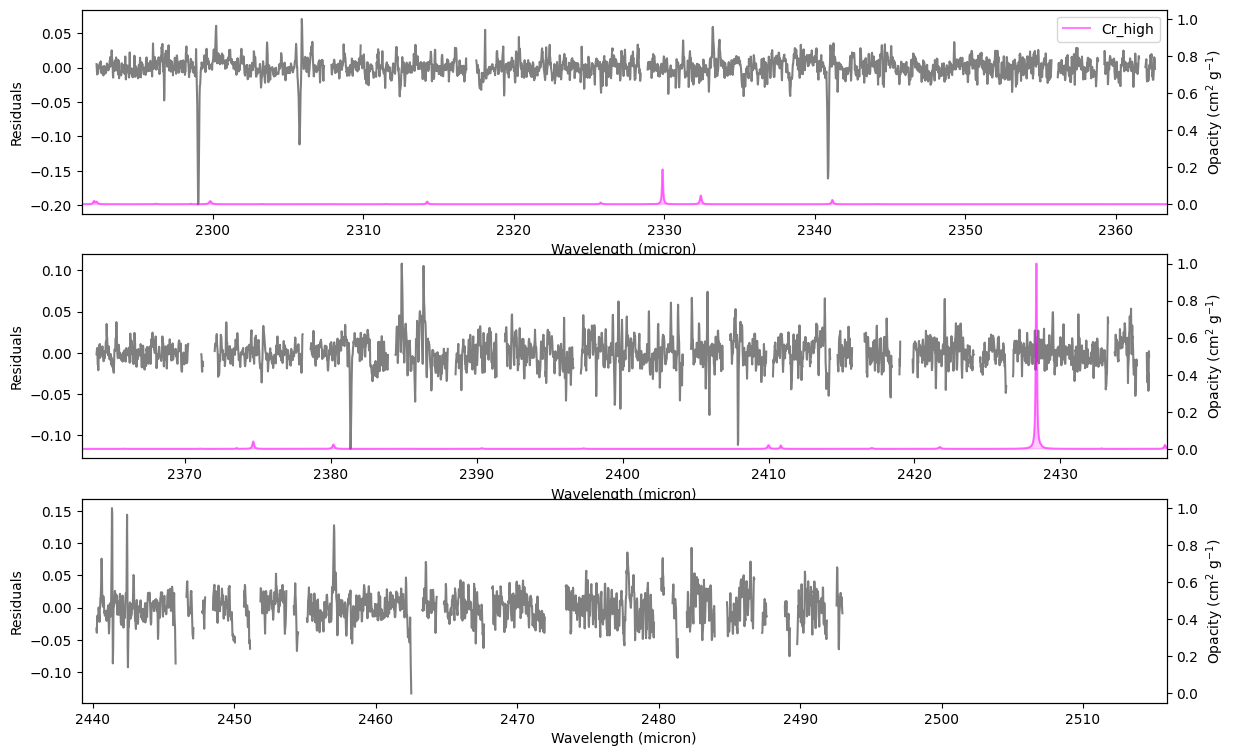

Plotting Sc_high...


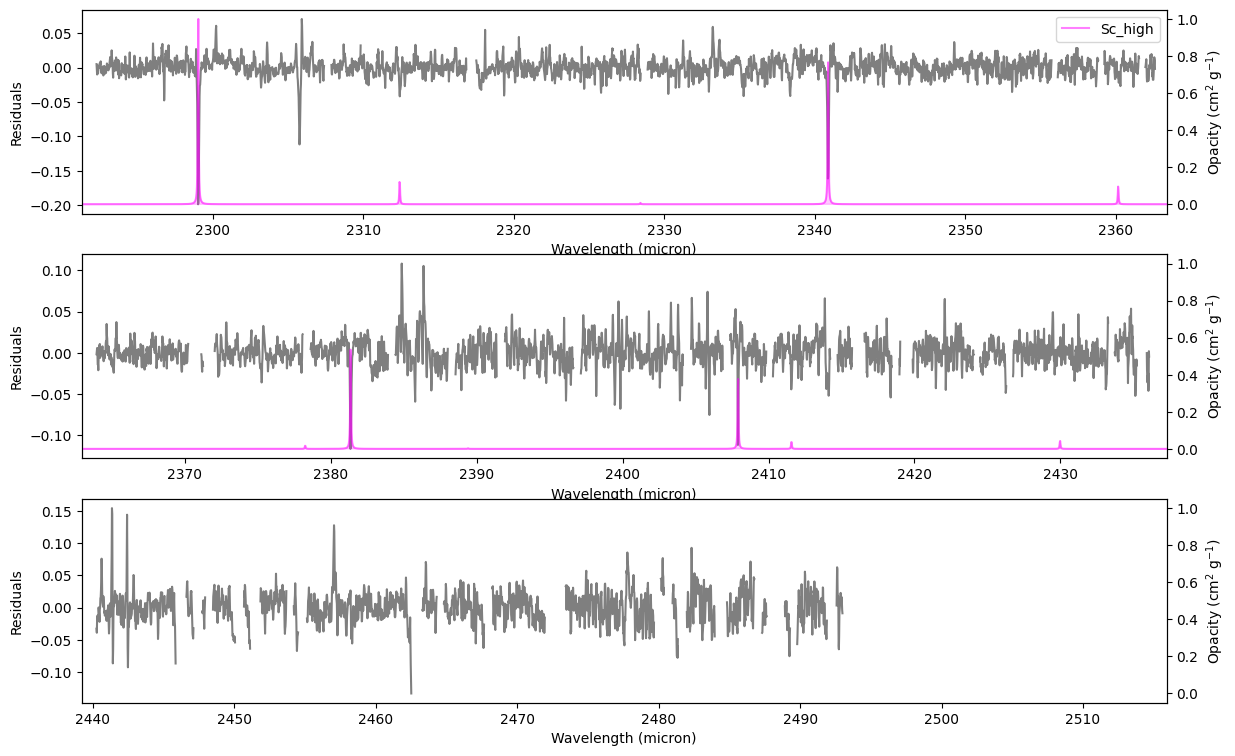

Plotting Li_high...


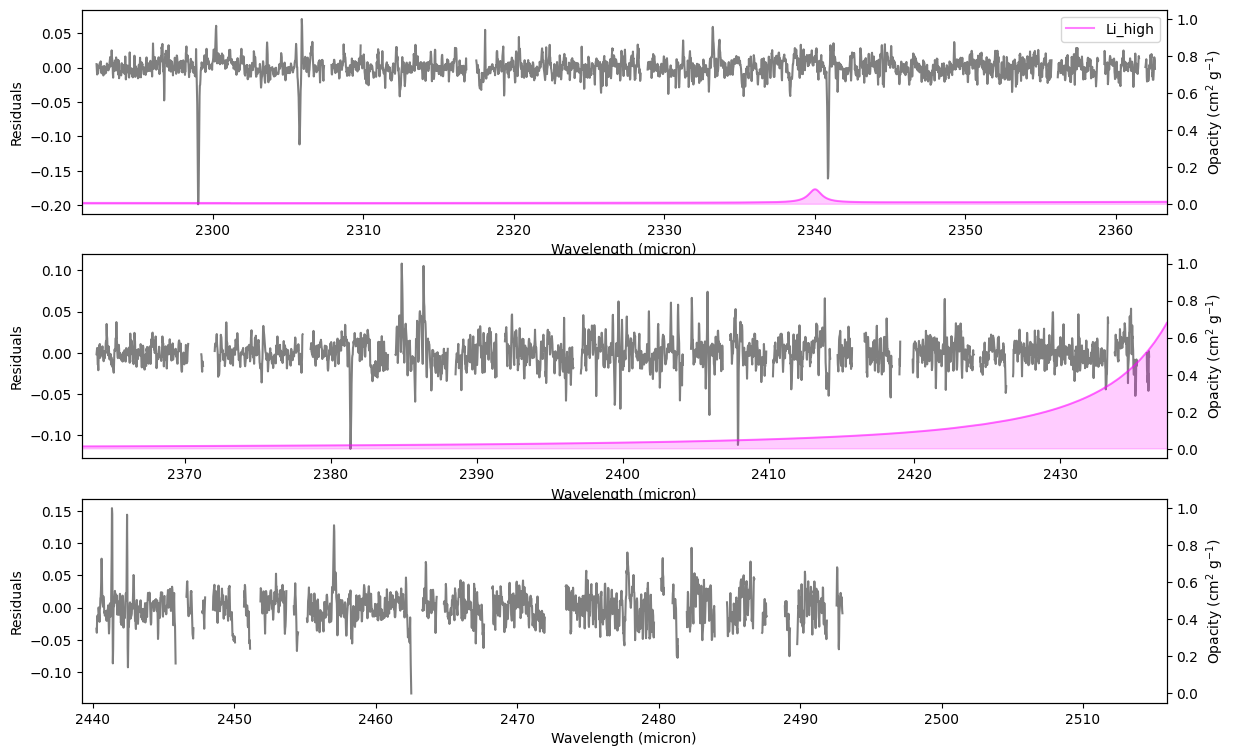

Plotting V_high...


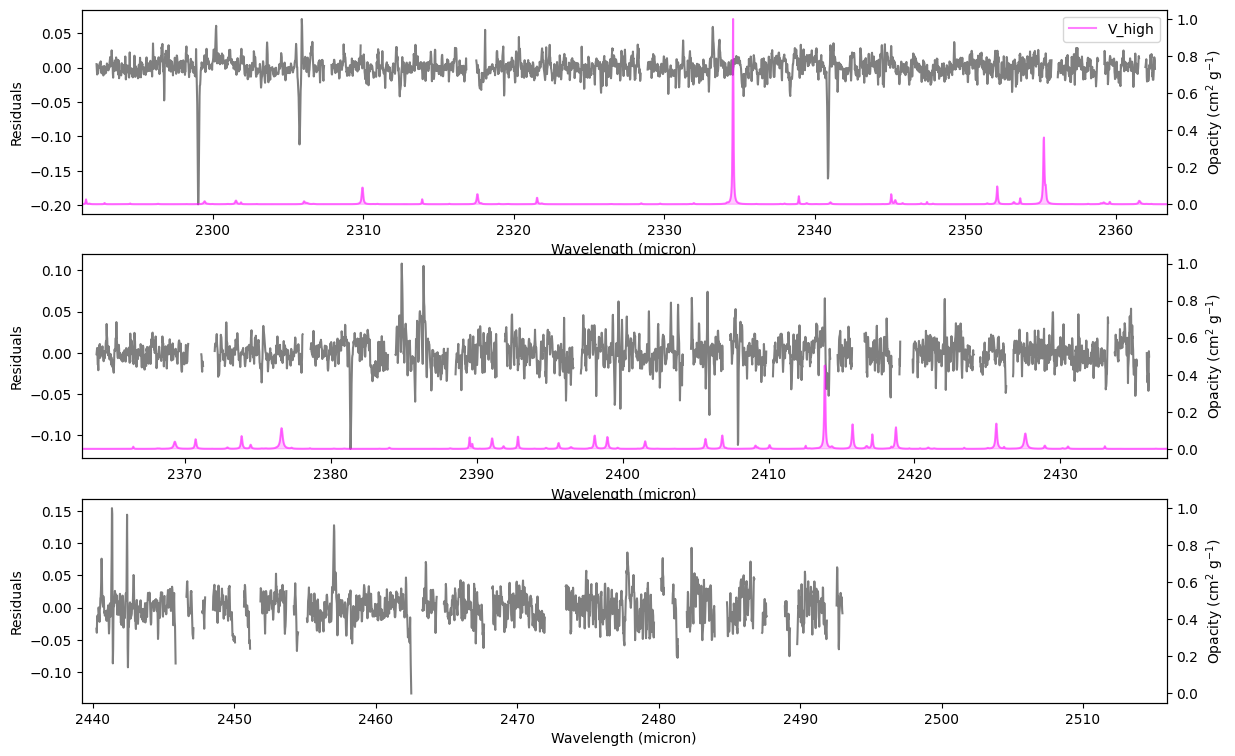

Plotting Co_high...


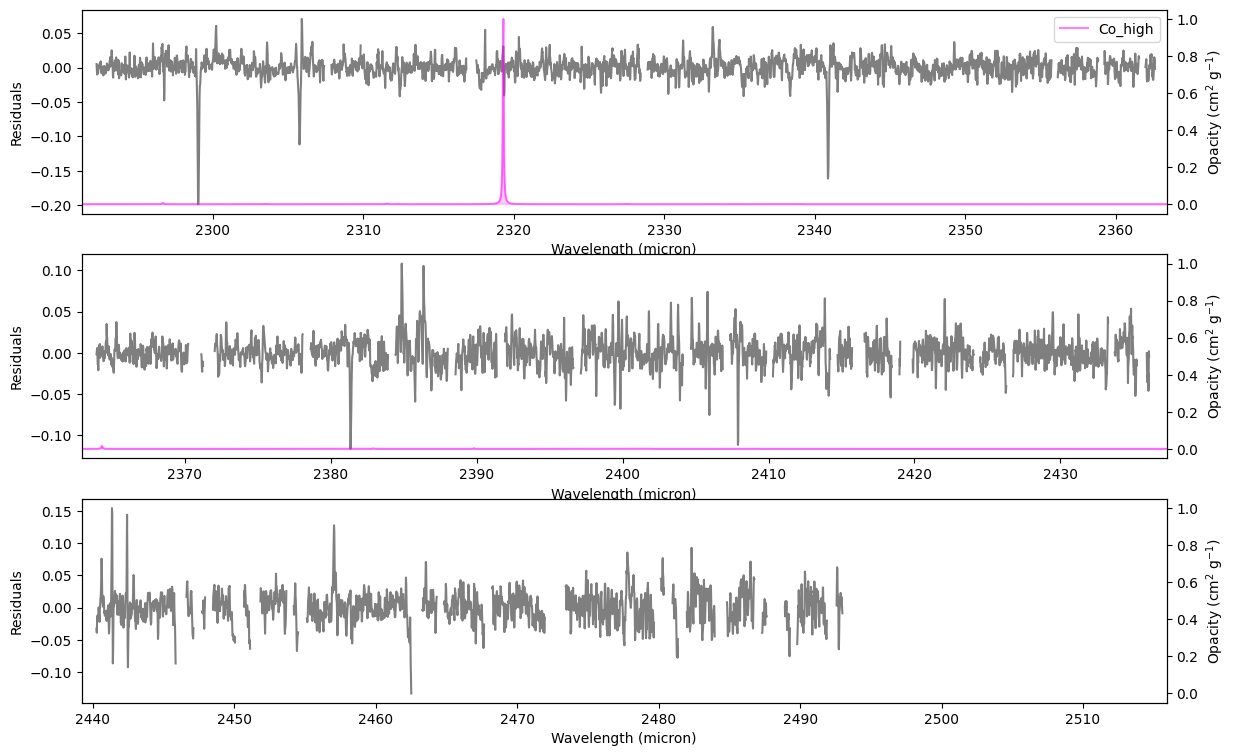

Plotting Zn_high...


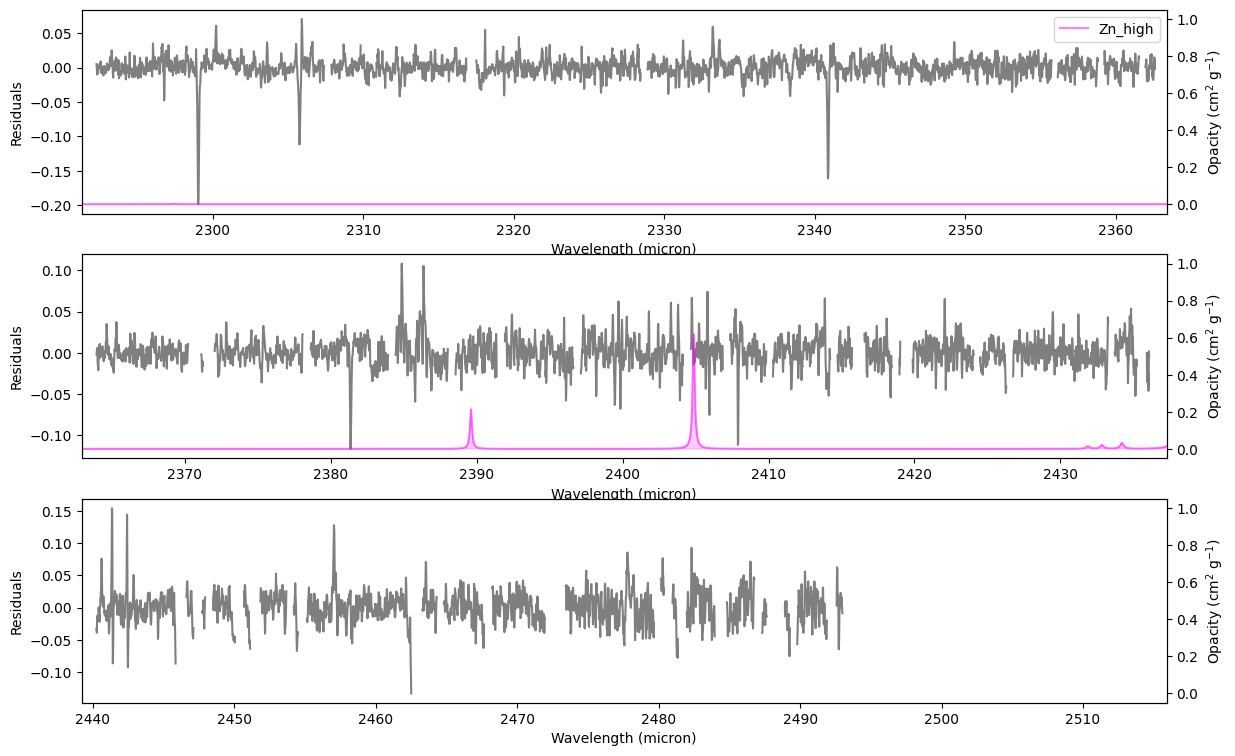

Plotting Mn_high...


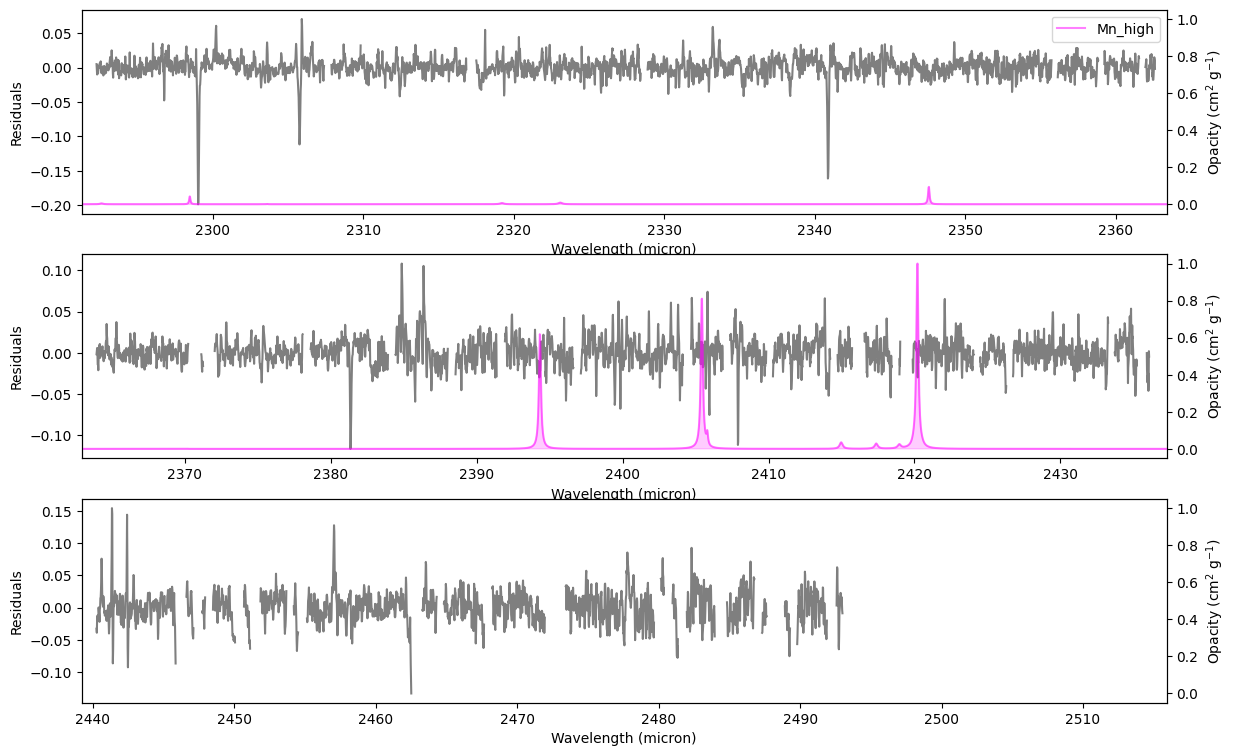

Plotting Ba_high...


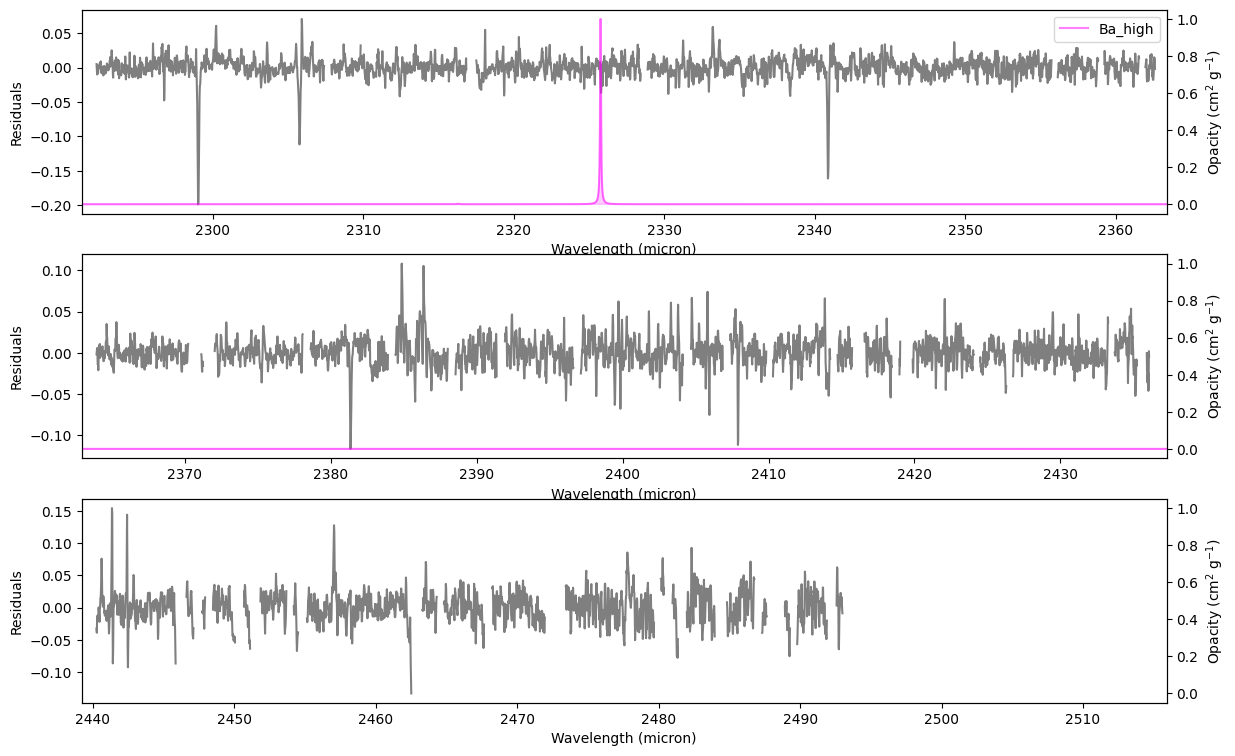

Plotting Rb_high...


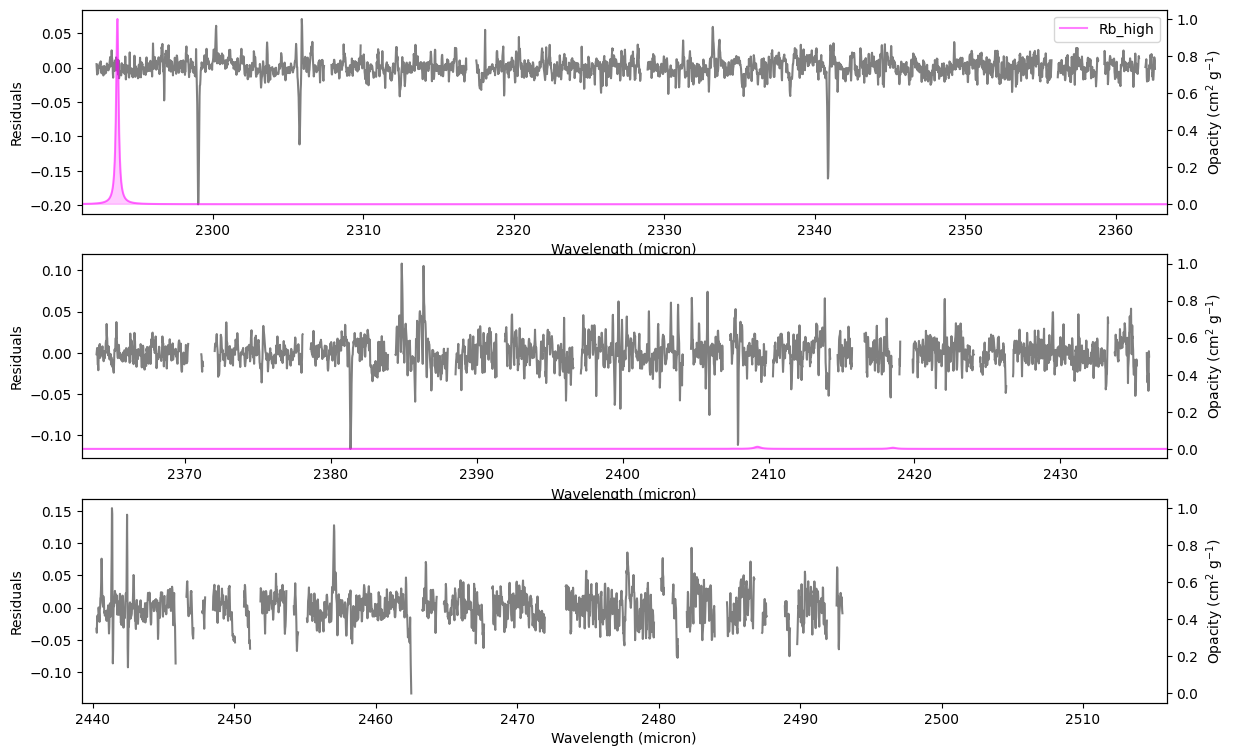

Plotting Mg...


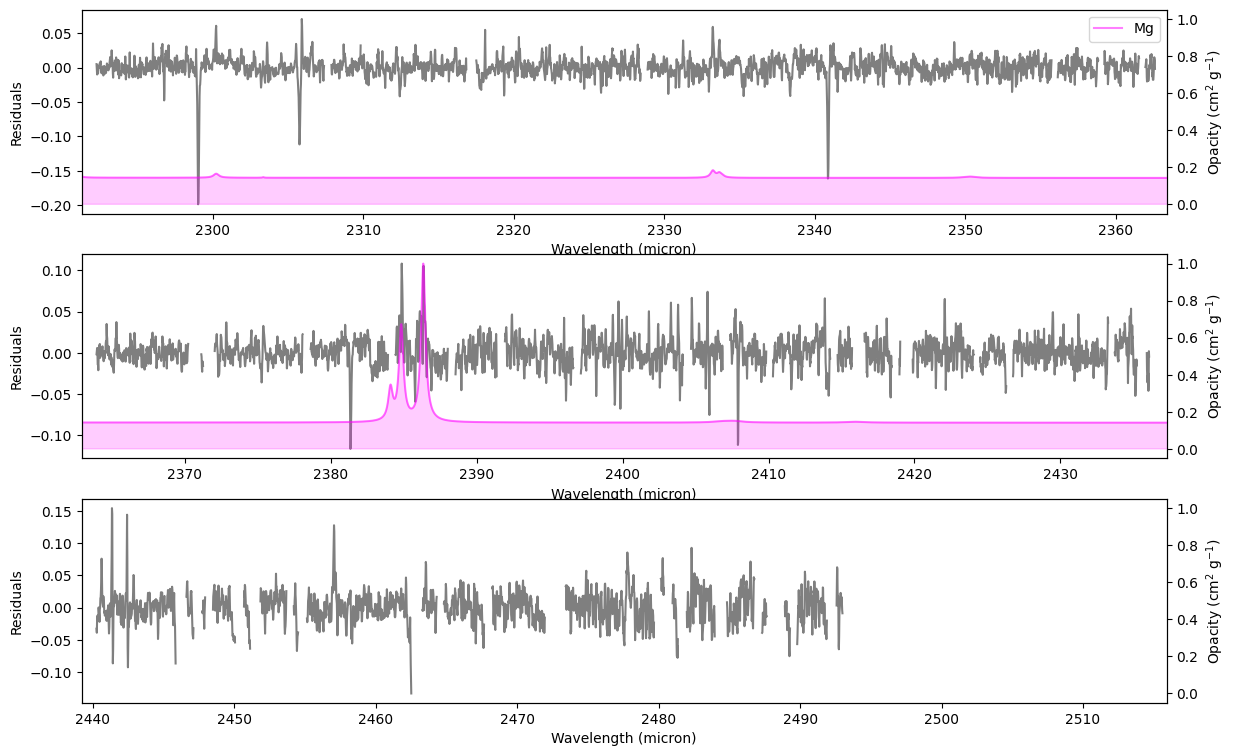

In [21]:

def plot_residuals_atoms(linelists, **kwargs):
    fig, ax = plt.subplots(n_orders, 1, figsize=(14, 3*n_orders))
    ax_twins = [ax[i].twinx() for i in range(n_orders)]
    for order in range(n_orders):
        ax[order].plot(wave[order], res[order], label='Residuals', color='k', alpha=0.5)
        for i, linelist in enumerate(linelists):
            linelist.plot(ax=ax_twins[order], vmr=1.0, fill=True, fill_gradient=False, 
                        label=linelist.species, 
                        color=kwargs.get('color', 'C'+str(i)),
                        alpha=kwargs.get('alpha', 0.5),
                        ls=kwargs.get('ls', '-'),
                        )
            
            # linelist.plot(ax=ax[order], vmr=1.0, fill=True, fill_gradient=True, label=linelist.species)
        wmin, wmax = wave[order][0], wave[order][-1]
        ax[order].set(xlabel='Wavelength (micron)', ylabel='Residuals', xlim=(wmin, wmax))
        ax_twins[order].set(ylabel='Opacity (cm$^2$ g$^{-1}$)', xlim=(wmin, wmax), yscale='linear')
        if order==0:
            ax_twins[order].legend(ncol=len(linelists))
        
for linelist in linelists:
    print(f'Plotting {linelist.species}...')
    plot_residuals_atoms([linelist], color='magenta', alpha=0.5)
    plt.show()
